In [1]:
import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.autograd import Variable

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Generate data

In [12]:
n = 2500    # number of data points
d = 1       # number of features
t = 1       # number of targets
x_train = np.random.uniform(0, 1, (n, d)).astype(np.float32)
noise   = np.random.uniform(-0.1, 0.1, (n, d)).astype(np.float32)
y_train = np.sin(2*np.pi*x_train) + noise
x_test  = np.linspace(0, 1, n).reshape(-1, d).astype(np.float32)

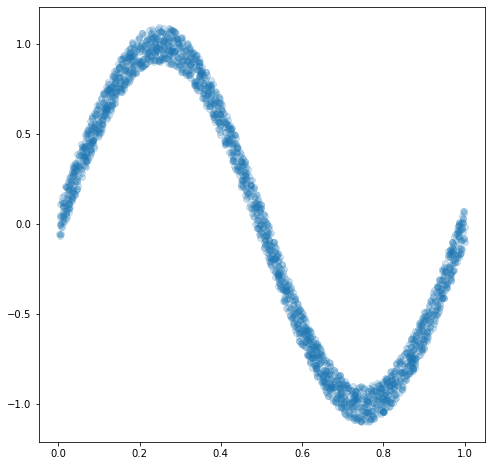

In [3]:
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'o', alpha=0.2)
plt.show()

# Train a model

In [4]:
# define a simple neural net
h = 50  # number of hidden units
k = 3   # number of mixing components

d_pi = k        
d_sigmasq = k
d_mu = t*k 

w1 = Variable(torch.randn(d, h) * np.sqrt(1/(d+h)), requires_grad=True)
b1 = Variable(torch.zeros(1, h), requires_grad=True)
w_pi = Variable(torch.randn(h, d_pi) * np.sqrt(2/(d+h)), requires_grad=True)
b_pi = Variable(torch.zeros(1, d_pi), requires_grad=True)
w_sigmasq = Variable(torch.randn(h, d_sigmasq) * np.sqrt(2/(d+h)), requires_grad=True)
b_sigmasq = Variable(torch.zeros(1, d_sigmasq), requires_grad=True)
w_mu = Variable(torch.randn(h, d_mu) * np.sqrt(2/(d+h)), requires_grad=True)
b_mu = Variable(torch.zeros(1, d_mu), requires_grad=True)

def forward(x):
    out = torch.tanh(x.mm(w1) + b1)
    pi = F.softmax(out.mm(w_pi) + b_pi, dim=1)
    sigmasq = torch.exp(out.mm(w_sigmasq) + b_sigmasq)
    mu = out.mm(w_mu) + b_mu
    return pi, sigmasq, mu

def gaussian_pdf(x, mu, sigmasq):
    return torch.exp(-(x-mu)**2/(2*sigmasq))/torch.sqrt(2*np.pi*sigmasq)

def loss_fn(pi, sigmasq, mu, target):
    losses = Variable(torch.zeros(n, n))  # p(y|x)
    for i in range(k):  # marginalize over z
        likelihood_z_x = gaussian_pdf(target, mu[:, i*t:(i+1)*t], sigmasq[:, i])
        prior_z = pi[:, i]
        losses += prior_z * likelihood_z_x
    loss = torch.mean(-torch.log(losses))
    return loss


# wrap up the data as Variables
x = Variable(torch.from_numpy(x_train))
y = Variable(torch.from_numpy(y_train))

# select an optimizer
opt = optim.Adam([w1, b1, w_pi, b_pi, w_sigmasq, b_sigmasq, w_mu, b_mu], lr=0.02)

# optimize
for e in range(1000):
    opt.zero_grad()
    pi, sigmasq, mu = forward(x)
    loss = loss_fn(pi, sigmasq, mu, y)
    print(e, loss.data.numpy(), end='\r')
    loss.backward()
    opt.step()

In [5]:
def sample_mode(pi, sigmasq, mu):
    n, k = pi.shape
    _, kt = mu.shape
    t = int(kt/k)
    _, max_component = torch.max(pi, dim=1) # mixture with largest probability
    out = Variable(torch.zeros(n, t))
    for i in range(n):
        for j in range(t):
            out[i, j] = mu[i, max_component[i]*t + j]
    return out

def sample_preds(pi, sigmasq, mu, samples=10):
    N, K = pi.shape
    _, KT = mu.shape
    T = int(KT / K)
    out = Variable(torch.zeros(N, samples, T))  # s samples per example
    for i in range(N):
        for j in range(samples):
            # pi must sum to 1, thus we can sample from a uniform
            # distribution, then transform that to select the component
            u = np.random.uniform()  # sample from [0, 1)
            # split [0, 1] into k segments: [0, pi[0]), [pi[0], pi[1]), ..., [pi[K-1], pi[K])
            # then determine the segment `u` that falls into and sample from that component
            prob_sum = 0
            for k in range(K):
                prob_sum += pi.data[i, k]
                if u < prob_sum:
                    # sample from the kth component
                    for t in range(T):
                        sample = np.random.normal(mu.data[i, k*T+t], np.sqrt(sigmasq.data[i, k]))
                        out[i, j, t] = sample
                    break
    return out

In [6]:
# sample
pi, sigmasq, mu = forward(Variable(torch.from_numpy(x_test)))
cond_mode = sample_mode(pi, sigmasq, mu)
preds = sample_preds(pi, sigmasq, mu, samples=10)

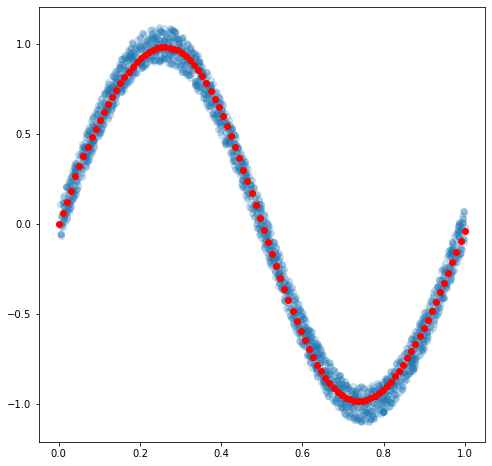

In [7]:
# plot the conditional mode at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'o', alpha=0.2)
plt.plot(x_test, cond_mode.data.numpy(), 'ro')
plt.show()

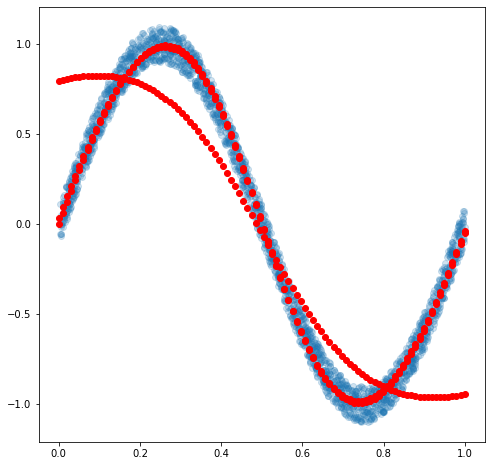

In [8]:
# plot the means at each point along x
fig = plt.figure(figsize=(8, 8))
plt.plot(x_train, y_train, 'o', alpha=0.2)
plt.plot(x_test, mu.data.numpy(), 'ro')
plt.show()

ValueError: cannot reshape array of size 100 into shape (2500,1)

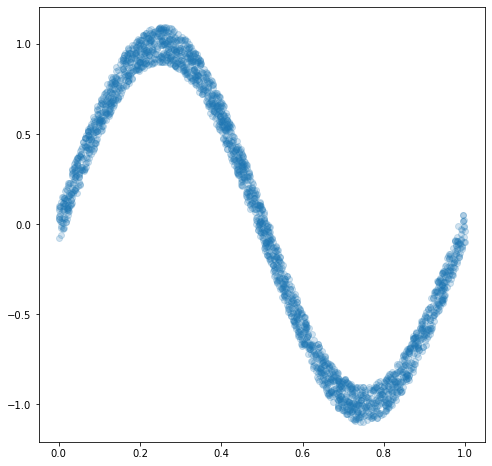

In [13]:
# plot sampled predictions at each point along x
fig = plt.figure(figsize=(8,8))
plt.plot(x_train, y_train, 'o', alpha=0.2)
for i in range(preds.shape[1]):
  plt.plot(x_test, preds.data.numpy()[:, i].reshape(n, 1), 'ro', alpha=0.2)
plt.show()